

# collab



<a href="https://colab.research.google.com/github/stonehenge0/AI-verstehen-Winteraka-2024-25/blob/main/H%C3%A4lfte%201/optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Optimization

In today's material focuses on understanding the standard methods of optimisation in machine learning. You're going to learn about the training loop and different optimizers.

## Gradient Descent

In the preparation work, you have seen how backpropagation works. Today, we're going to use the gradients produced by backpropagation for optimizing a loss function using gradient descent.

A loss function can be any differentiable function such that we prefer a lower value. To apply gradient descent, we start by initializing the parameters to random values (the details of this are subtle), and then repeatedly compute the gradient of the loss with respect to the model parameters. It [can be proven](https://tutorial.math.lamar.edu/Classes/CalcIII/DirectionalDeriv.aspx) that for an infinitesimal step, moving in the direction of the gradient would increase the loss by the largest amount out of all possible directions.

We actually want to decrease the loss, so we subtract the gradient to go in the opposite direction. Taking infinitesimal steps is no good, so we pick some learning rate $\lambda$ (also called the step size) and scale our step by that amount to obtain the update rule for gradient descent:

$$ \theta_t \leftarrow \theta_{t-1} - \lambda \nabla L(\theta_{t-1}) $$


## Hyperparameters

The learning rate is an example of a **hyperparameter**, which will be described below. As a reminder, a regular parameter is an adjustable value with the special and extremely convenient property that we can differentiate the loss with respect to the parameter, allowing us to efficiently learn good values for the parameter using gradient descent. In other words, the process of training is a function that takes a dataset, a model architecture, and a random seed and outputs model parameters.

The learning rate, in contrast, cannot be determined by this scheme. As a hyperparameter, we need to introduce an outer loop that wraps the training loop to search for good learning rate values. This outer loop is called a hyperparameter search, and each iteration consists of testing different combinations of hyperparameters using a dataset of pairs of $(\text{hyperparameters}, \text{validation performance})$. Obtaining results for each iteration (a single pair) requires running the inner training loop.

Due to a fixed budget of ML researcher time and available compute, we are interested in a trade-off between the ML researcher time, the cost of running the search, and the cost of training the final model. Due to the vast search space and cost of obtaining data, we don't hope to find any sort of optimum but merely to improve upon our initial guesses enough to justify the cost.

In addition, a hyperparameter isn't necessarily a single continuous value like the learning rate. Discrete unordered choices such as padding type as well as discrete ordered choices such as the number of layers in the network or the width of each convolution are all common. You will also need to choose between functions for optimizers, nonlinearities, or learning rate scheduling, of which there are an infinite number of possibilities, requiring us to select a small subset to test.

More broadly, every design decision can be considered a hyperparameter, including how to preprocess the input data, the connectivity of different layers, the types of operations, etc. Papers such as [AmeobaNet](https://arxiv.org/pdf/1801.01548.pdf) demonstrated that it's possible to find architectures superior to human-designed ones.

In the second part of today's material, you will learn about various strategies for searching over hyperparameters.

## Stochastic Gradient Descent

The terms gradient descent and SGD are used loosely in deep learning. To be technical, there are three variations:

- Batch gradient descent - the loss function is the loss over the entire dataset. This requires too much computation unless the dataset is small, so it is rarely used in deep learning.
- Stochastic gradient descent - the loss function is the loss on a randomly selected example. Any particular loss may be completely in the wrong direction of the loss on the entire dataset, but in expectation it's in the right direction. This has some nice properties but doesn't parallelize well, so it is rarely used in deep learning.
- Mini-batch gradient descent - the loss function is the loss on a batch of examples of size `batch_size`. This is the standard in deep learning.

The class `torch.SGD` can be used for any of these by varying the number of examples passed in. We will be using only mini-batch gradient descent in this course.

## Batch Size

In addition to choosing a learning rate or learning rate schedule, we need to choose the batch size or batch size schedule as well. Intuitively, using a larger batch means that the estimate of the gradient is closer to that of the true gradient over the entire dataset, but this requires more compute. Each element of the batch can be computed in parallel so with sufficient compute, one can increase the batch size without increasing wall-clock time. For small-scale experiments, a good heuristic is thus "fill up all of your GPU memory".

At a larger scale, we would expect diminishing returns of increasing the batch size, but empirically it's worse than that - a batch size that is too large generalizes more poorly in many scenarios. The intuition that a closer approximation to the true gradient is always better is therefore incorrect. See [this paper](https://arxiv.org/pdf/1706.02677.pdf) for one discussion of this.

For a batch size schedule, most commonly you'll see batch sizes increase over the course of training. The intuition is that a rough estimate of the proper direction is good enough early in training, but later in training it's important to preserve our progress and not "bounce around" too much.

You will commonly see batch sizes that are a multiple of 32. One motivation for this is that when using CUDA, threads are grouped into "warps" of 32 threads which execute the same instructions in parallel. So a batch size of 64 would allow two warps to be fully utilized, whereas a size of 65 would require waiting for a third warp to finish. As batch sizes become larger, this wastage becomes less important.

Powers of two are also common - the idea here is that work can be recursively divided up among different GPUs or within a GPU. For example, a matrix multiplication can be expressed by recursively dividing each matrix into four equal blocks and performing eight smaller matrix multiplications between the blocks.

## Computing Gradients in PyTorch

Recall that gradients are only saved for `Tensor`s for which `requires_grad=True`. For convenience, `nn.Parameter` automatically sets `requires_grad=True` on the wrapped `Tensor`. As you call `torch` functions, PyTorch tracks the relevant information needed in case you call `backward` later on, at which point it does the actual computation to compute the gradient and stores it in the `Tensor`'s `grad` field.

Also recall that PyTorch accumulates gradients across multiple `backward` calls. So if your tensor's `grad` already contains a value, after calling `backward` again it will have the sum of the original value and the new gradient. This behavior comes in handy in many situations, such as computing gradients over multiple runs on a GPU as part of a single batch. Suppose you choose a batch size of 32, but only 8 inputs fit on your GPU. A typical loss function for a batch computes the sum of losses over each example, so you can compute the losses 8 at a time and sum their gradients, producing the same result as running all 32 inputs at once.

### Stopping gradients with `torch.no_grad` or `torch.inference_mode`

You may not want PyTorch to track gradients for some computations despite involving tensors with `requires_grad=True`. In this case, you can wrap the computation in the `with torch.inference_mode()` context to prevent this tracking.


In this notebook, we will discuss the most popular optimizers used in training neural networks. You will implement optimizers from simple to compex:
- Stochastic Gradient Descent (SGD)
- SGD with Momentum
- RMSprop
- Adam

> ## Learning Objectives
> - Understand what optimizers are and why they are used
> - Get an intuition for momentum and RMS
> - Underatand what the differnet hyperparameters in Adam are and how they affect the training process


In [1]:
from typing import Iterable, Union, Optional, List, Tuple
import matplotlib.pyplot as plt
import torch as t

# Test funcitons

Just execute the code block bellow, without looking at it. Those funcitons are just there to check your own implementations against the behaciour of the torch original


In [3]:
from typing import Iterable, Union, Optional, List, Tuple
import matplotlib.pyplot as plt
import matplotlib.figure
import torch as t
from einops import repeat
import numpy as np

def rosenbrocks_banana(x: t.Tensor, y: t.Tensor, a=1, b=100) -> t.Tensor:
    return (a - x) ** 2 + b * (y - x**2) ** 2 + 1

def optimize_function(
    function: callable, parameters: t.Tensor, optimizer, n_steps: int
) -> List[t.Tensor]:
    trajectory = []
    for _ in range(n_steps):
        trajectory.append(parameters.detach().clone())
        loss = function(*parameters)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    trajectory = t.stack(trajectory).float()
    return trajectory


def test_SGD(optimizer_class):
    parameters = t.tensor([-1.0, 2.0], requires_grad=True)
    N_steps = 100
    learning_rate = 0.001
    optimizer = optimizer_class(parameters, learning_rate)

    test_trajectory = optimize_function(
        rosenbrocks_banana, parameters, optimizer, N_steps
    )

    parameters = t.tensor([-1.0, 2.0], requires_grad=True)
    solution_optimizer = t.optim.SGD([parameters], lr=learning_rate)
    solution_trajectory = optimize_function(
        rosenbrocks_banana, parameters, solution_optimizer, N_steps
    )

    assert t.allclose(test_trajectory, solution_trajectory, atol=1e-3)

    print("SGD test passed")


def test_momentum(optimizer_class):
    parameters = t.tensor([-1.0, 2.0], requires_grad=True)
    N_steps = 100
    learning_rate = 0.001
    optimizer = optimizer_class(parameters, learning_rate, momentum=0.9)

    test_trajectory = optimize_function(
        rosenbrocks_banana, parameters, optimizer, N_steps
    )

    parameters = t.tensor([-1.0, 2.0], requires_grad=True)
    adjested_learning_rate = learning_rate * (1 - 0.9)
    solution_optimizer = t.optim.SGD(
        [parameters], lr=adjested_learning_rate, momentum=0.9
    )
    solution_trajectory = optimize_function(
        rosenbrocks_banana, parameters, solution_optimizer, N_steps
    )

    assert t.allclose(test_trajectory, solution_trajectory, atol=1e-3)

    print("Momentum test passed")


def test_RMSprop(optimizer_class):
    parameters = t.tensor([-1.0, 2.0], requires_grad=True)
    N_steps = 100
    learning_rate = 0.001
    epsilon = 1e-8
    optimizer = optimizer_class(
        parameters, learning_rate, beta=0.9, epsilon=epsilon
    )

    test_trajectory = optimize_function(
        rosenbrocks_banana, parameters, optimizer, N_steps
    )

    parameters = t.tensor([-1.0, 2.0], requires_grad=True)
    solution_optimizer = t.optim.RMSprop(
        [parameters], lr=learning_rate, alpha=0.9, eps=epsilon
    )
    solution_trajectory = optimize_function(
        rosenbrocks_banana, parameters, solution_optimizer, N_steps
    )

    assert t.allclose(test_trajectory, solution_trajectory, atol=1e-3)

    print("RMSprop test passed")


def test_Adam(optimizer_class):
    parameters = t.tensor([-1.0, 2.0], requires_grad=True)
    N_steps = 100
    learning_rate = 0.001
    epsilon = 1e-8
    optimizer = optimizer_class(
        parameters,
        learning_rate,
        momentum_grad=0.9,
        momentum_grad_squared=0.999,
        epsilon=epsilon,
    )

    test_trajectory = optimize_function(
        rosenbrocks_banana, parameters, optimizer, N_steps
    )

    parameters = t.tensor([-1.0, 2.0], requires_grad=True)
    solution_optimizer = t.optim.Adam(
        [parameters], lr=learning_rate, betas=(0.9, 0.999)
    )
    solution_trajectory = optimize_function(
        rosenbrocks_banana, parameters, solution_optimizer, N_steps
    )

    assert t.allclose(test_trajectory, solution_trajectory, atol=1e-3)

    print("Adam test passed")



def plot_rosenbrock(
    trajectories={}, xmin=-2, xmax=2, ymin=-1, ymax=3, n_points=50
) -> matplotlib.figure.Figure:
    """Plot the rosenbrocks_banana function in 3D and its contour plot over the specified domain with trajectories."""

    global_minimum = t.tensor([1, 1])

    fig = plt.figure(figsize=(12, 5))

    # 3D plot
    ax1 = fig.add_subplot(121, projection="3d")
    x = t.linspace(xmin, xmax, n_points)
    y = t.linspace(ymin, ymax, n_points)
    xx = repeat(x, "x -> y x", y=n_points)
    yy = repeat(y, "y -> y x", x=n_points)
    zs = rosenbrocks_banana(xx, yy)
    ax1.plot_surface(xx, yy, zs, cmap="viridis", alpha=0.5)

    for label, trajectory in trajectories.items():
        ax1.plot(
            trajectory[:, 0],
            trajectory[:, 1],
            rosenbrocks_banana(trajectory[:, 0], trajectory[:, 1]),
            label=label,
            linewidth=4.0,
        )
    # plot the global minimum
    ax1.scatter(
        *global_minimum,
        rosenbrocks_banana(*global_minimum),
        color="red",
        label="Global Minimum"
    )

    ax1.set(xlabel="x", ylabel="y", zlabel="z")
    ax1.legend()

    # Contour plot
    ax2 = fig.add_subplot(122)
    zs = rosenbrocks_banana(xx, yy)

    levels = np.logspace(np.log10(zs.min()), np.log10(zs.max()), 10)
    contour = ax2.contour(x, y, zs, levels=levels, cmap="viridis")

    cbar = fig.colorbar(contour, ax=ax2)
    cbar.ax.set_ylabel("Function Value")

    for label, trajectory in trajectories.items():
        ax2.plot(trajectory[:, 0], trajectory[:, 1], label=label, linewidth=4.0)

    # plot the global minimum
    ax2.scatter(*global_minimum, color="red", label="Global Minimum")

    ax2.set(xlabel="x", ylabel="y")
    ax2.legend()

    plt.tight_layout()
    return fig


# Exercise
The job of an optimizer is to find the minimum in a Loss funciton. The loss function, we are going to consider here is Rosenbrocks Banana function. 
Of cause, in practice, loss funcitons are verry high dimensional and not so simple. But we have an easier time plotting 2D functions.

In [ ]:

def rosenbrocks_banana(x: t.Tensor, y: t.Tensor, a=1, b=100) -> t.Tensor:
    """
    Computes the value of the Rosenbrock's banana function.

    The Rosenbrock's banana function is a non-convex function used as a performance test problem for optimization algorithms. 
    It is defined as:
        f(x, y) = (a - x)^2 + b * (y - x^2)^2 + 1

    Args:
        x (t.Tensor): The x-coordinate input tensor.
        y (t.Tensor): The y-coordinate input tensor.
        a (int, optional): The parameter 'a' of the function. Default is 1.
        b (int, optional): The parameter 'b' of the function. Default is 100.

    Returns:
        t.Tensor: The computed value of the Rosenbrock's banana function.
    """
    return (a - x) ** 2 + b * (y - x**2) ** 2 + 1

trajectories = {}
plot_rosenbrock(trajectories)
plt.show()

### Exercise - Implement the training loop and Stochastic Gradient Descent (SGD) optimizer
(2-5 mins)

The training loop consists of the following steps:
 - Compute the loss
- Compute the gradients
- Update the parameters
- zero the gradients

The update rule for Stochastic Gradient Descent (SGD) is given by:

$$\theta_{t+1} = \theta_t - \alpha \cdot \nabla_\theta \text{Loss}(\theta_t)$$

where:
- $\theta_t$ represents the model's parameters at iteration $t$.
- $\alpha$ is the learning rate, which determines the step size of the parameter updates.
- $\nabla_\theta \text{Loss}(\theta_t)$ denotes the gradient of the loss function $\text{Loss}$ with respect to the parameters $\theta_t$.

In [69]:
def optimize_function( function: callable, parameters: t.Tensor, optimizer, n_steps: int, breakif: callable = lambda params, loss: True) -> List[t.Tensor]:
    trajectory = []
    parameters.requires_grad = True
    print(parameters)
    for i in range(n_steps):
        trajectory.append(parameters.detach().clone())
        loss = function(*parameters)
        loss.backward()
        # if i % 10 == 9:
        #     print(i, "th step, loss: ", loss.detach().numpy())
        if breakif(parameters.detach().numpy(), loss.detach().numpy()):
            break
        optimizer.step()
        optimizer.zero_grad()
    trajectory = t.stack(trajectory).float()
    return trajectory

class StocasticGradientDescent:
    def __init__(self, parameters: t.Tensor, learning_rate: float):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self):
        with t.no_grad():
            self.parameters -= self.learning_rate * self.parameters.grad
   
    def zero_grad(self):
        self.parameters.grad.zero_()

test_SGD(StocasticGradientDescent)


tensor([-1.,  2.], requires_grad=True)
tensor([-1.,  2.], requires_grad=True)
SGD test passed


In [7]:
import numpy as np
np.array([1,2])+np.array([[3],[4]])

array([[4, 5],
       [5, 6]])

<details>
<summary>Solution Training loop</summary>
        

```python
def optimize_function( function: callable, parameters: t.Tensor, optimizer, n_steps: int) -> List[t.Tensor]:
    trajectory = []
    for _ in range(n_steps):
        trajectory.append(parameters.detach().clone())
        loss = function(*parameters)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    trajectory = t.stack(trajectory).float()
    return trajectory
```

</details>

<details>
<summary>Solution SGD</summary>
        

```python
class StocasticGradientDescent:
    def __init__(self, parameters: t.Tensor, learning_rate: float):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self):
        with t.no_grad():
            self.parameters -= self.learning_rate * self.parameters.grad

    def zero_grad(self):
        self.parameters.grad.zero_()
```

</details>


In [31]:
trajectories = {}

9 th step, loss:  6.4858837
19 th step, loss:  6.4568954
29 th step, loss:  6.4300294
39 th step, loss:  6.4030933
49 th step, loss:  6.3760834
59 th step, loss:  6.3490005
69 th step, loss:  6.321844
79 th step, loss:  6.294612
89 th step, loss:  6.267303
99 th step, loss:  6.2399187


/tmp/ipykernel_15723/3907702068.py:168: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  levels = np.logspace(np.log10(zs.min()), np.log10(zs.max()), 10)


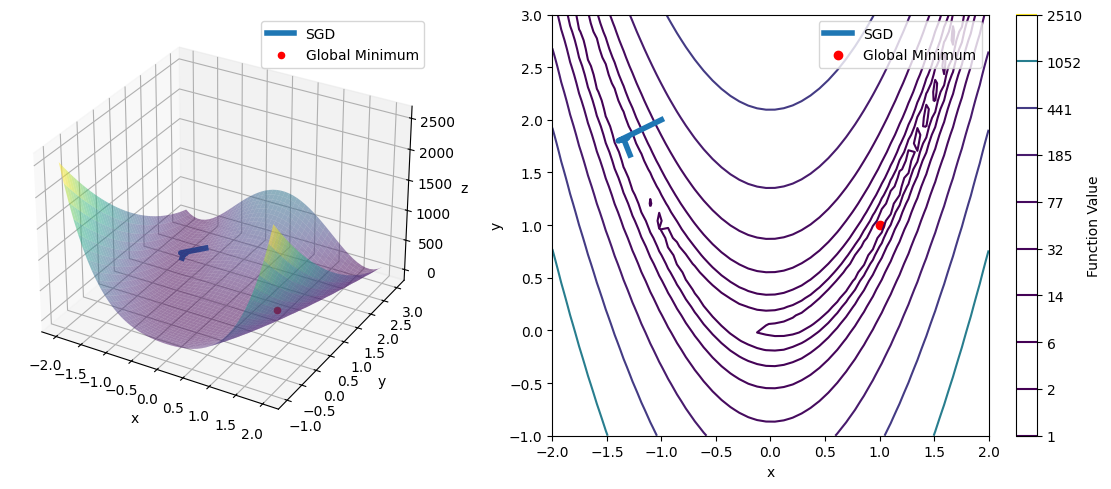

In [32]:
parameters = t.tensor([-1.0, 2.0], requires_grad=True)

N_steps = 100
learning_rate = 0.001
optimizer = StocasticGradientDescent(parameters, learning_rate)

trajectories["SGD"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)
plot_rosenbrock(trajectories)
plt.show()

### Exercise - Implement the training loop and Stochastic Gradient Descent with Momentum optimizer
(2-5 mins)

When we have momentum in our optimizer, we additioally keep track of the "velocity" with wich we are currently moving $m_t$. The update rule for Stochastic Gradient Descent with Momentum is given by:

$$m_{t+1} = \beta \cdot m_t + (1 - \beta) \cdot \nabla_\theta \text{Loss}(\theta_t)$$
$$\theta_{t+1} = \theta_t - \alpha \cdot m_{t+1}$$

where:
- $\beta$ is the momentum parameter, which determines how much of the previous velocity we keep.
- $m_t$ represents the running average of the velocity at iteration $t$.



In [34]:
class Momentum:
    def __init__(self, parameters: t.Tensor, learning_rate: float, momentum: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.momentum_param = momentum
        self.momentum = 0

    def step(self):
        with t.no_grad():
            self.momentum = self.momentum_param * self.momentum + (1 - self.momentum_param) * self.parameters.grad
            self.parameters -= self.learning_rate * self.momentum

    def zero_grad(self):
        self.parameters.grad.zero_()

test_momentum(Momentum)


9 th step, loss:  33.327946
19 th step, loss:  6.95866
29 th step, loss:  8.23402
39 th step, loss:  7.6644454
49 th step, loss:  6.3920774
59 th step, loss:  6.0451117
69 th step, loss:  6.0332828
79 th step, loss:  6.003592
89 th step, loss:  5.9600716
99 th step, loss:  5.92579
9 th step, loss:  33.327946
19 th step, loss:  6.958662
29 th step, loss:  8.234013
39 th step, loss:  7.66444
49 th step, loss:  6.3920746
59 th step, loss:  6.0451126
69 th step, loss:  6.0332828
79 th step, loss:  6.003592
89 th step, loss:  5.9600725
99 th step, loss:  5.9257913
Momentum test passed


<details>
<summary>Solution Momentum</summary>
        

```python
class Momentum:
    def __init__(self, parameters: t.Tensor, learning_rate: float, momentum: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.average_grad = t.zeros_like(parameters)

    def step(self):
        with t.no_grad():
            self.average_grad = self.momentum * self.average_grad + (1 - self.momentum) * self.parameters.grad
            self.parameters -= self.learning_rate * self.average_grad

    def zero_grad(self):
        self.parameters.grad.zero_()

```

</details>

9 th step, loss:  33.271694
19 th step, loss:  1.5389323
29 th step, loss:  2.5407948
39 th step, loss:  1.7390382
49 th step, loss:  1.2108382
59 th step, loss:  1.0011516
69 th step, loss:  1.0274043
79 th step, loss:  1.0099059
89 th step, loss:  1.0007567
99 th step, loss:  1.0019535


/tmp/ipykernel_15723/3907702068.py:168: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  levels = np.logspace(np.log10(zs.min()), np.log10(zs.max()), 10)


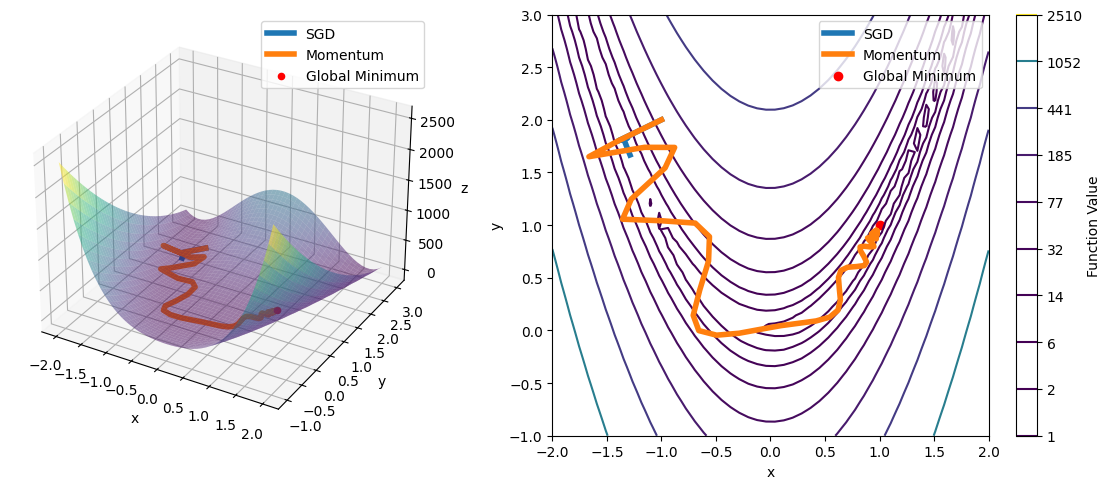

In [35]:

parameters = t.tensor([-1.0, 2.0], requires_grad=True)
N_steps = 100
learning_rate = 0.01
momentum = 0.9
optimizer = Momentum(parameters, learning_rate, momentum)
trajectories["Momentum"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)
plot_rosenbrock(trajectories)
plt.show()

### Exercise - Implement RMSprop optimizer
(2-5 mins)

RMSprop is an optimizer that adapts the learning rate for each parameter. To do that, we keep track of the moving average of the squared gradients $r_t$ and update the parameters as follows:

$$r_{t+1} = \beta \cdot r_t + (1 - \beta) \cdot \nabla_\theta \text{Loss}(\theta_t)^2$$
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{r_{t+1} + \epsilon}} \cdot \nabla_\theta \text{Loss}(\theta_t)$$

where:
- $\beta$ is the momentum parameter, which determines how much of the previous squared gradients we keep.
- $r_t$ represents the moving average of the squared gradients at iteration $t$.
- $\epsilon$ is a small value added to the denominator to avoid division by zero.


In [38]:
class RMSProp:
    def __init__(self, parameters: t.Tensor, learning_rate: float, beta: float, epsilon: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.rms_parameter = beta
        self.epsilon = epsilon
        self.rms = 0


    def step(self):
        with t.no_grad():
            self.rms = self.rms_parameter * self.rms + (1 - self.rms_parameter) * self.parameters.grad ** 2
            self.parameters -= self.learning_rate / t.sqrt(self.rms + self.epsilon) * self.parameters.grad

    def zero_grad(self):
        self.parameters.grad.zero_()


test_RMSprop(RMSProp)

9 th step, loss:  95.65343
19 th step, loss:  89.31273
29 th step, loss:  83.70973
39 th step, loss:  78.42726
49 th step, loss:  73.35589
59 th step, loss:  68.46291
69 th step, loss:  63.739346
79 th step, loss:  59.184284
89 th step, loss:  54.799503
99 th step, loss:  50.587776
9 th step, loss:  95.65343
19 th step, loss:  89.31273
29 th step, loss:  83.70973
39 th step, loss:  78.42726
49 th step, loss:  73.35589
59 th step, loss:  68.46291
69 th step, loss:  63.739346
79 th step, loss:  59.184284
89 th step, loss:  54.799503
99 th step, loss:  50.587776
RMSprop test passed


<details>
<summary>Solution RMSprop</summary>
        

```python
class RMSProp:
    def __init__(self, parameters: t.Tensor, learning_rate: float, beta: float, epsilon: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = epsilon
        self.squared_gradients = t.zeros_like(parameters)

    def step(self):
        with t.no_grad():
            self.squared_gradients = self.beta * self.squared_gradients + (1 - self.beta) * self.parameters.grad ** 2
            self.parameters -= self.learning_rate / t.sqrt(self.squared_gradients + self.epsilon) * self.parameters.grad

    def zero_grad(self):
        self.parameters.grad.zero_()
```

</details>

9 th step, loss:  6.0929885
19 th step, loss:  6.0158854
29 th step, loss:  8.556313
39 th step, loss:  6.0864153
49 th step, loss:  8.340149
59 th step, loss:  15.879217
69 th step, loss:  10.278152
79 th step, loss:  8.28318
89 th step, loss:  7.853171
99 th step, loss:  6.4333305


/tmp/ipykernel_15723/3907702068.py:168: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  levels = np.logspace(np.log10(zs.min()), np.log10(zs.max()), 10)


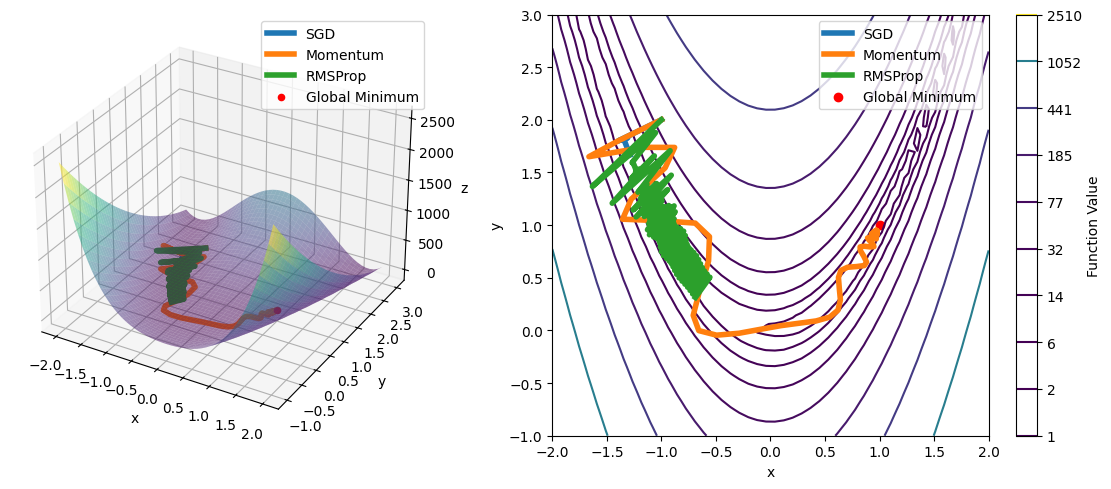

In [39]:
parameters = t.tensor([-1.0, 2.0], requires_grad=True)
N_steps = 100
learning_rate = 0.2
beta = 0.9
epsilon = 1e-8
optimizer = RMSProp(parameters, learning_rate, beta, epsilon)
trajectories["RMSProp"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)

plot_rosenbrock(trajectories)
plt.show()

### Exercise - Implement Adam optimizer
(2-5 mins)

For the Adam optimizer, we now bring both momentum and RMSprop together. We keep track of the moving average of the gradients $m_t$ and the moving average of the squared gradients $r_t$ and update the parameters as follows:

$$m_{t+1} = \beta_1 \cdot m_t + (1 - \beta_1) \cdot \nabla_\theta \text{Loss}(\theta_t)$$
$$r_{t+1} = \beta_2 \cdot r_t + (1 - \beta_2) \cdot \nabla_\theta \text{Loss}(\theta_t)^2$$
$$\hat{m}_{t+1} = \frac{m_{t+1}}{1 - \beta_1^{t+1}}$$
$$\hat{r}_{t+1} = \frac{r_{t+1}}{1 - \beta_2^{t+1}}$$

$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{\hat{r}_{t+1} + \epsilon}} \cdot \hat{m}_{t+1}$$

where:
- $\beta_1$ and $\beta_2$ are the momentum parameters for the gradients and squared gradients, respectively.
- $m_t$ and $r_t$ represent the moving averages of the gradients and squared gradients at iteration $t$.
- $\hat{m}_{t+1}$ and $\hat{r}_{t+1}$ are the bias-corrected moving averages.
- $\epsilon$ is a small value added to the denominator to avoid division by zero.


In [43]:
class Adam:
    def __init__(self, parameters: t.Tensor, learning_rate: float, momentum_grad: float, momentum_grad_squared: float, epsilon: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.momentum_param = momentum_grad
        self.rms_param = momentum_grad_squared
        self.momentum = 0
        self.rms = 0
        self.t = 0

    def step(self):
        with t.no_grad():
            self.t += 1
            self.rms = self.rms_param * self.rms + (1 - self.rms_param) * self.parameters.grad ** 2
            self.momentum = self.momentum_param * self.momentum + (1 - self.momentum_param) * self.parameters.grad
            rms = self.rms / (1 - self.rms_param ** self.t)
            momentum = self.momentum / (1 - self.momentum_param ** self.t)
            self.parameters -= self.learning_rate / t.sqrt (rms + epsilon) * momentum

    def zero_grad(self):
        self.parameters.grad.zero_()


test_Adam(Adam)


9 th step, loss:  99.69659
19 th step, loss:  93.96181
29 th step, loss:  88.4144
39 th step, loss:  83.06939
49 th step, loss:  77.935425
59 th step, loss:  73.01699
69 th step, loss:  68.31548
79 th step, loss:  63.830826
89 th step, loss:  59.56197
99 th step, loss:  55.50698
9 th step, loss:  99.69659
19 th step, loss:  93.96181
29 th step, loss:  88.4144
39 th step, loss:  83.06939
49 th step, loss:  77.935425
59 th step, loss:  73.01699
69 th step, loss:  68.31548
79 th step, loss:  63.830826
89 th step, loss:  59.56197
99 th step, loss:  55.50698
Adam test passed


<details>
<summary>Solution Adam</summary>
        

```python
class Adam:
    def __init__(self, parameters: t.Tensor, learning_rate: float, momentum_grad: float, momentum_grad_squared: float, epsilon: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.momentum_grad = momentum_grad
        self.momentum_grad_squared = momentum_grad_squared
        self.epsilon = epsilon
        self.average_grad = t.zeros_like(parameters)
        self.average_squared_grad = t.zeros_like(parameters)
        self.t = 0

    def step(self):
        with t.no_grad():
            self.t += 1
            self.average_grad = self.momentum_grad * self.average_grad + (1 - self.momentum_grad) * self.parameters.grad
            self.average_squared_grad = self.momentum_grad_squared * self.average_squared_grad + (1 - self.momentum_grad_squared) * self.parameters.grad ** 2
            average_grad_hat = self.average_grad / (1 - self.momentum_grad ** self.t)
            average_squared_grad_hat = self.average_squared_grad / (1 - self.momentum_grad_squared ** self.t)
            self.parameters -= self.learning_rate * average_grad_hat / (t.sqrt(average_squared_grad_hat) + self.epsilon)

    def zero_grad(self):
        self.parameters.grad.zero_()
```

</details>


9 th step, loss:  4.863632
19 th step, loss:  4.372718
29 th step, loss:  6.1577396
39 th step, loss:  4.103055
49 th step, loss:  2.170807
59 th step, loss:  1.3174515
69 th step, loss:  1.0093526
79 th step, loss:  1.0346105
89 th step, loss:  1.015532
99 th step, loss:  1.0040056


/tmp/ipykernel_15723/3907702068.py:168: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  levels = np.logspace(np.log10(zs.min()), np.log10(zs.max()), 10)


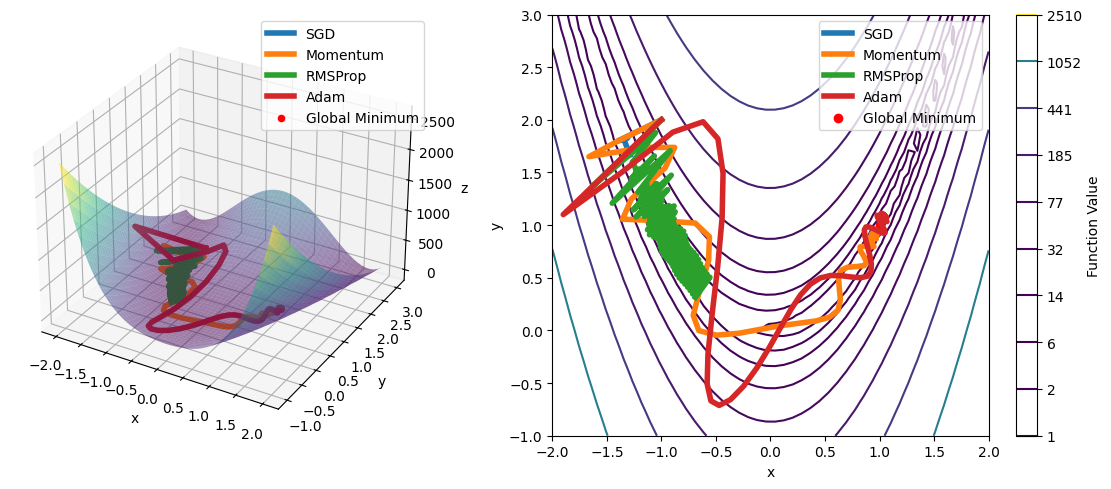

In [44]:

parameters = t.tensor([-1.0, 2.0], requires_grad=True)

N_steps = 100
learning_rate = 0.9
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
optimizer = Adam(parameters, learning_rate, beta1, beta2, epsilon)

trajectories["Adam"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)
plot_rosenbrock(trajectories)
plt.show()

### BONUS Exercise - Play around with the hyperparameters

Play around with learning rates, the betas and epsilon.

Challange until time is up: get within a 1e-2 range of the minimum of the banana function in as few steps as possible.

In [78]:
from itertools import product
from math import inf

N_steps = 10000
learning_rate = [0.87,0.88,0.89]
beta1 = [0.902,0.905,0.908]
beta2 = [0.999,0.99905]
epsilon = [1e-16]

minimum, argmin = inf, None
for (learning_rate, beta1 , beta2, epsilon) in product(learning_rate, beta1 , beta2, epsilon):
    parameters = t.tensor([-1.0, 2.0], requires_grad=True)
    optimizer = Adam(parameters, learning_rate, beta1, beta2, epsilon)
    trajectory = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps, breakif=lambda params, loss: np.linalg.norm(params - np.array([1,1])) < 1e-2 )
    num_steps = len(trajectory)
    hyper_params = (learning_rate, beta1 , beta2, epsilon)
    print(num_steps, hyper_params)
    if num_steps < minimum:
        minimum = num_steps
        argmin = hyper_params

print(minimum, argmin)

tensor([-1.,  2.], requires_grad=True)
314 (0.87, 0.902, 0.999, 1e-16)
tensor([-1.,  2.], requires_grad=True)
312 (0.87, 0.902, 0.99905, 1e-16)
tensor([-1.,  2.], requires_grad=True)
515 (0.87, 0.905, 0.999, 1e-16)
tensor([-1.,  2.], requires_grad=True)
516 (0.87, 0.905, 0.99905, 1e-16)
tensor([-1.,  2.], requires_grad=True)
37 (0.87, 0.908, 0.999, 1e-16)
tensor([-1.,  2.], requires_grad=True)
37 (0.87, 0.908, 0.99905, 1e-16)
tensor([-1.,  2.], requires_grad=True)
493 (0.88, 0.902, 0.999, 1e-16)
tensor([-1.,  2.], requires_grad=True)
493 (0.88, 0.902, 0.99905, 1e-16)
tensor([-1.,  2.], requires_grad=True)
37 (0.88, 0.905, 0.999, 1e-16)
tensor([-1.,  2.], requires_grad=True)
37 (0.88, 0.905, 0.99905, 1e-16)
tensor([-1.,  2.], requires_grad=True)
615 (0.88, 0.908, 0.999, 1e-16)
tensor([-1.,  2.], requires_grad=True)
617 (0.88, 0.908, 0.99905, 1e-16)
tensor([-1.,  2.], requires_grad=True)
533 (0.89, 0.902, 0.999, 1e-16)
tensor([-1.,  2.], requires_grad=True)
534 (0.89, 0.902, 0.99905, 1e-